<a href="https://colab.research.google.com/github/GuptaNavdeep1983/CS688/blob/main/Question5-TopicModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

https://datascience.stackexchange.com/questions/54904/how-to-avoid-tokenizing-w-sklearn-feature-extraction


https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

https://www.freecodecamp.org/news/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04/

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.transform

https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html

https://github.com/brandomr/document_cluster/blob/master/cluster_analysis.ipynb

In [1]:
pip install gensim

In [2]:
import statsmodels.api as sm 
import pylab as py 
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
import datetime
from zipfile import ZipFile
from gzip import decompress
from json import loads
from requests import get
import requests, zipfile, io
from bs4 import BeautifulSoup
import math
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
import gensim
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_texts
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_punctuation2, strip_short, strip_numeric, stem_text
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
def get_crowd_funding_data_links(filter_by_years):
    # get the content of the website
    content = urllib.request.urlopen('https://webrobots.io/indiegogo-dataset/').read()
    soup = BeautifulSoup(content,features='html.parser')
    
    all_stories = pd.DataFrame([], columns=['Year', 'Month', 'json', 'csv'])
    parent_div = soup.find(name='div', attrs={'class':'fusion-text'})

    # Iterate through the divs to find the list of Month-Year wise anchor tags
    index = 0
    for year_data in parent_div.find_all(name='ul'):
        all_months = year_data.find_all('li')
        for month in all_months:
            complete_text = month.text
            date_time_obj = datetime.datetime.strptime((complete_text.split('[')[0]).strip(), '%Y-%m-%d')
            if date_time_obj.year in filter_by_years:
                all_stories.loc[index, "Year"] = date_time_obj.year
                all_stories.loc[index, "Month"] = str(date_time_obj.month) if date_time_obj.month >=10 else f'0{date_time_obj.month}'
                all_stories.loc[index, "json"] = month.find_all('a')[0]["href"]
                all_stories.loc[index, "csv"] = month.find_all('a')[1]["href"]
                index = index + 1
    return all_stories

def get_current_index_data(df, indx, columns):
    r = requests.get(df["csv"][indx])
    z = zipfile.ZipFile(io.BytesIO(r.content))
    csv_data = z.open("Indiegogo.csv")
    data_df = pd.read_csv(csv_data, usecols=columns, dtype={'title':str, 'tagline':str})
    return data_df
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [5]:
df = get_crowd_funding_data_links([2020])
stemmer = SnowballStemmer("english")
documents = []
for indx in df.head(5).index:
    current_month_data = get_current_index_data(df, indx, ["title", "tagline"])
    current_month_data.dropna(axis=0, inplace=True)
    for index, row in current_month_data.iterrows():
      all_content = preprocess(row['tagline'])
      documents.append(all_content)

In [6]:
common_dictionary = corpora.Dictionary(documents)
common_dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [ ]:
df = pd.DataFrame(documents, columns=['content'])
vectorizer = CountVectorizer(input='content',stop_words='english', analyzer='word', token_pattern=r'\b[a-zA-Z]{2,}\b',max_features=100)
doc_term_matrix = vectorizer.fit_transform(df['content'])
# doc_term_matrix = vectorizer.transform(df['content'])
feature_names = vectorizer.get_feature_names()
df_dictionary = pd.DataFrame(feature_names)
dictionary = df_dictionary.to_dict()[0]
# df_doc_term_matrix = pd.DataFrame(doc_term_matrix.toarray())
term_doc_matrix = doc_term_matrix.transpose()

In [7]:

common_corpus = [common_dictionary.doc2bow(doc) for doc in documents]


In [8]:
print(common_corpus[1])

[(2, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]


In [9]:
def create_gensim_lsi_model(common_corpus, common_dictionary):
    # generate LSI model
    lsamodel = LsiModel(common_corpus, id2word = common_dictionary, num_topics=5)  # train model
    print(lsamodel.print_topics())
    return lsamodel

In [13]:
def create_gensim_lda_model(common_corpus, common_dictionary):
    # generate LDA model
    lsamodel = gensim.models.LdaMulticore(common_corpus, num_topics=5, id2word=common_dictionary, passes=3, workers=2)  # train model
    print(lsamodel.print_topics())
    return lsamodel

In [11]:
lsi_model = create_gensim_lsi_model(common_corpus=common_corpus, common_dictionary=common_dictionary)


[(0, '0.521*"world" + 0.395*"game" + 0.218*"need" + 0.190*"support" + 0.177*"fund" + 0.148*"creat" + 0.131*"book" + 0.121*"music" + 0.117*"power" + 0.117*"rais"'), (1, '-0.833*"game" + 0.428*"world" + -0.132*"play" + 0.117*"need" + -0.113*"card" + -0.097*"board" + 0.089*"fund" + 0.060*"rais" + 0.054*"support" + -0.054*"player"'), (2, '-0.659*"world" + 0.371*"fund" + 0.348*"need" + 0.287*"support" + 0.240*"rais" + -0.154*"game" + 0.130*"book" + 0.091*"music" + 0.091*"communiti" + 0.069*"creat"'), (3, '-0.558*"fund" + -0.355*"rais" + 0.348*"support" + 0.241*"power" + 0.232*"design" + -0.230*"world" + -0.164*"need" + -0.128*"game" + 0.126*"life" + 0.117*"creat"'), (4, '-0.846*"need" + 0.306*"fund" + 0.238*"book" + 0.225*"rais" + 0.097*"creat" + 0.094*"music" + 0.071*"power" + 0.066*"design" + 0.060*"publish" + 0.055*"money"')]


In [14]:
lda_model = create_gensim_lda_model(common_corpus, common_dictionary)

[(0, '0.013*"need" + 0.010*"album" + 0.009*"home" + 0.008*"fund" + 0.008*"support" + 0.007*"food" + 0.007*"right" + 0.006*"coffe" + 0.006*"beauti" + 0.006*"build"'), (1, '0.024*"power" + 0.016*"world" + 0.016*"design" + 0.012*"water" + 0.010*"electr" + 0.010*"bike" + 0.009*"protect" + 0.009*"energi" + 0.008*"charg" + 0.007*"light"'), (2, '0.031*"game" + 0.014*"communiti" + 0.014*"peopl" + 0.013*"support" + 0.009*"play" + 0.009*"creat" + 0.009*"live" + 0.009*"world" + 0.009*"music" + 0.008*"educ"'), (3, '0.021*"book" + 0.014*"stori" + 0.013*"seri" + 0.012*"fund" + 0.012*"film" + 0.008*"campaign" + 0.008*"rais" + 0.008*"life" + 0.007*"project" + 0.007*"adventur"'), (4, '0.016*"camera" + 0.011*"sound" + 0.010*"qualiti" + 0.010*"wireless" + 0.009*"audio" + 0.009*"world" + 0.008*"time" + 0.008*"control" + 0.008*"bluetooth" + 0.007*"smart"')]


In [16]:
from collections import OrderedDict
data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(5)}
data_lda

{0: OrderedDict([('need', 0.012990369),
              ('album', 0.009726088),
              ('home', 0.008532956),
              ('fund', 0.0081223175),
              ('support', 0.0075382562),
              ('food', 0.007218228),
              ('right', 0.0066636316),
              ('coffe', 0.0061487174),
              ('beauti', 0.0059523876),
              ('build', 0.005739454),
              ('creat', 0.0054835286),
              ('want', 0.005438319),
              ('bring', 0.005351294),
              ('grow', 0.005236025),
              ('record', 0.0051383167),
              ('make', 0.0051001436),
              ('natur', 0.005041955),
              ('free', 0.004893772),
              ('mind', 0.004854867),
              ('good', 0.004743647),
              ('give', 0.0047069746),
              ('plant', 0.0046644285),
              ('rais', 0.0046394174),
              ('hous', 0.0045065377),
              ('releas', 0.004504747)]),
 1: OrderedDict([('power', 0.024089966),


In [17]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)


(5, 102)


/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


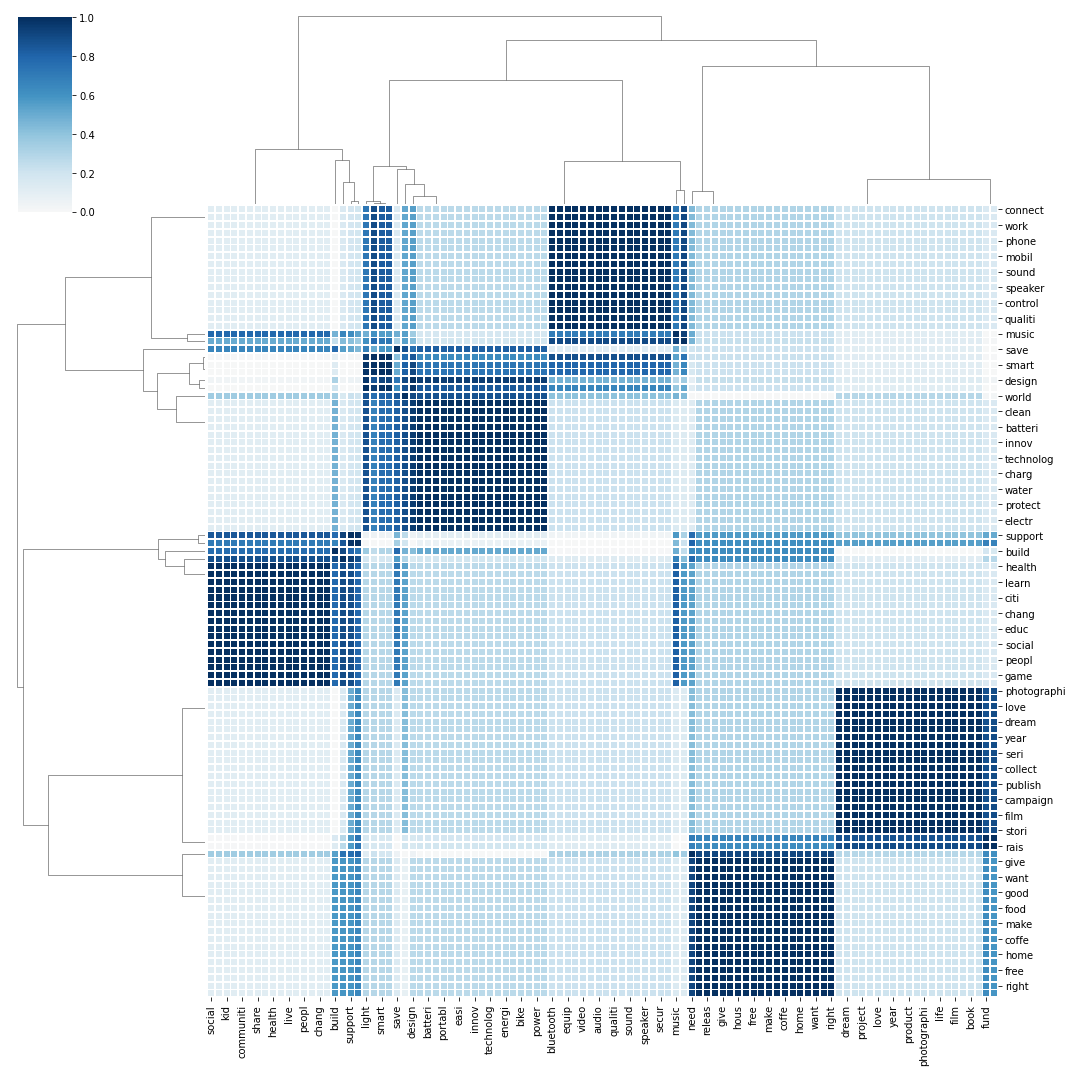

In [19]:
import seaborn as sns
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [ ]:
topics = lda_model.show_topics()
for topic in topics:
  terms = lda_model.get_topic_terms(topic[0])
  print(f"Topic:{topic[0]} Terms,")
  for term in terms:
    print(common_dictionary[term[0]])
# for tuple in out:

# lda_model.print_topics()
# lda_model.top_topics(corpus=common_corpus, dictionary=common_dictionary)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.021*"book" + 0.014*"stori" + 0.013*"seri" + 0.013*"film" + 0.012*"love" + 0.011*"life" + 0.010*"children" + 0.008*"bring" + 0.008*"come" + 0.007*"support"


Topic: 1 
Words: 0.019*"power" + 0.016*"design" + 0.012*"world" + 0.011*"smart" + 0.010*"light" + 0.009*"devic" + 0.009*"bike" + 0.008*"charg" + 0.008*"portabl" + 0.008*"wireless"


Topic: 2 
Words: 0.012*"album" + 0.012*"food" + 0.011*"support" + 0.011*"communiti" + 0.008*"creat" + 0.008*"festiv" + 0.008*"build" + 0.008*"need" + 0.007*"product" + 0.007*"music"


Topic: 3 
Words: 0.019*"rais" + 0.018*"fund" + 0.016*"need" + 0.011*"support" + 0.010*"music" + 0.010*"educ" + 0.009*"money" + 0.009*"video" + 0.008*"peopl" + 0.007*"communiti"


Topic: 4 
Words: 0.044*"game" + 0.018*"play" + 0.015*"world" + 0.012*"card" + 0.010*"real" + 0.009*"adventur" + 0.008*"action" + 0.007*"base" + 0.006*"board" + 0.006*"time"




In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram
dist = 1 - cosine_similarity(common_corpus)

ValueError: ignored

In [ ]:
import pandas as pd
import numpy as np
topicWordProbMat = lda_model.print_topics(-1)
columns = ['1','2','3','4','5']

df = pd.DataFrame(columns = columns)
pd.set_option('display.width', 1000)

# 40 will be resized later to match number of words in DC
zz = np.zeros(shape=(50,5))

last_number=0
DC={}

for x in range (10):
  data = pd.DataFrame({columns[0]:"",
                     columns[1]:"",
                     columns[2]:"",
                     columns[3]:"",
                     columns[4]:"",
                                                                                       
                     
                    },index=[0])
  df=df.append(data,ignore_index=True)  

distances = []    
for line in topicWordProbMat:
    print(line)
    tp, w = line
    probs=w.split("+")
    y=0
    for pr in probs:
               
        a=pr.split("*")
        df.iloc[y,tp] = a[1]
        distances.append(float(a[0]))
        if a[1] in DC:
           zz[DC[a[1]]][tp]=a[0]
        else:
           zz[last_number][tp]=a[0]
           DC[a[1]]=last_number
           last_number=last_number+1
        y=y+1

print (df)
print (zz)
print(distances)

(0, '0.021*"book" + 0.014*"stori" + 0.013*"seri" + 0.013*"film" + 0.012*"love" + 0.011*"life" + 0.010*"children" + 0.008*"bring" + 0.008*"come" + 0.007*"support"')
(1, '0.019*"power" + 0.016*"design" + 0.012*"world" + 0.011*"smart" + 0.010*"light" + 0.009*"devic" + 0.009*"bike" + 0.008*"charg" + 0.008*"portabl" + 0.008*"wireless"')
(2, '0.012*"album" + 0.012*"food" + 0.011*"support" + 0.011*"communiti" + 0.008*"creat" + 0.008*"festiv" + 0.008*"build" + 0.008*"need" + 0.007*"product" + 0.007*"music"')
(3, '0.019*"rais" + 0.018*"fund" + 0.016*"need" + 0.011*"support" + 0.010*"music" + 0.010*"educ" + 0.009*"money" + 0.009*"video" + 0.008*"peopl" + 0.007*"communiti"')
(4, '0.044*"game" + 0.018*"play" + 0.015*"world" + 0.012*"card" + 0.010*"real" + 0.009*"adventur" + 0.008*"action" + 0.007*"base" + 0.006*"board" + 0.006*"time"')
             1           2             3            4            5
0      "book"     "power"       "album"       "rais"       "game" 
1     "stori"    "design"     

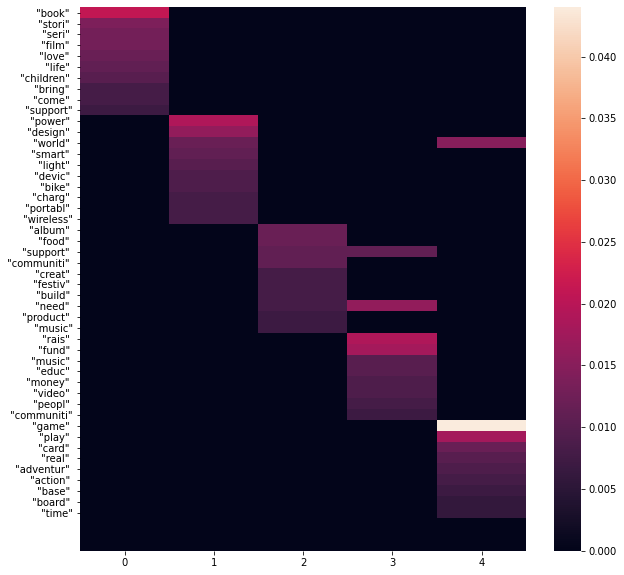

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10)) 
ax.set_ylabel("Median Population", fontname="Arial", fontsize=12)
ax = sns.heatmap(zz, yticklabels=DC.keys(), ax=ax)
